In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
%matplotlib inline

from prophet import Prophet

In [2]:
%load_ext autoreload
%autoreload 1

In [40]:
%aimport prophet_projpred
%aimport prophet_projpred.models

In [3]:
df = pd.read_csv('data/ecuador_dataset.csv')
df

,family,date,unit_sales,onpromotion,items,oil_price,precipitation,tavg,tmax,tmin,yellow maize,rice,white maize,wheat flour,wheat,potatoes
0,AUTOMOTIVE,2013-01-02,123.000,0.0,20.0,93.14,0.0,13.80,17.4,5.00,18.07,1.04,0.58,38.0,17.27,0.35
1,AUTOMOTIVE,2013-01-03,82.000,0.0,20.0,92.97,0.0,13.80,18.6,7.20,18.07,1.04,0.58,38.0,17.27,0.35
2,AUTOMOTIVE,2013-01-04,71.000,0.0,20.0,93.12,0.8,13.70,18.6,8.00,18.07,1.04,0.58,38.0,17.27,0.35
3,AUTOMOTIVE,2013-01-05,184.000,0.0,20.0,93.12,0.0,14.45,19.9,7.35,18.07,1.04,0.58,38.0,17.27,0.35
4,AUTOMOTIVE,2013-01-06,198.000,0.0,20.0,93.12,2.0,15.20,21.2,6.70,18.07,1.04,0.58,38.0,17.27,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55369,SEAFOOD,2017-08-10,433.118,0.0,8.0,48.54,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30
55370,SEAFOOD,2017-08-11,765.204,73.0,8.0,48.81,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30
55371,SEAFOOD,2017-08-12,613.881,6.0,8.0,48.81,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30
55372,SEAFOOD,2017-08-13,700.469,0.0,8.0,48.81,0.0,13.20,19.6,5.80,18.50,1.19,0.29,33.4,11.70,0.30


In [4]:
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
holidays = holidays[holidays['locale_name'].isin(['Quito', 'Ecuador'])]
holidays = holidays.sort_values(by=['description', 'date']).reset_index()
holidays = holidays[['date', 'description']].rename(columns={'date': 'ds', 'description': 'holiday'})
holidays

,ds,holiday
0,2013-05-24,Batalla de Pichincha
1,2014-05-24,Batalla de Pichincha
2,2015-05-24,Batalla de Pichincha
3,2016-05-24,Batalla de Pichincha
4,2017-05-24,Batalla de Pichincha
...,...,...
182,2013-04-29,Viernes Santo
183,2014-04-18,Viernes Santo
184,2015-04-03,Viernes Santo
185,2016-03-25,Viernes Santo


In [57]:
m = prophet_projpred.ReferenceModel(changepoint_prior_scale=0.01, holidays=holidays, mcmc_samples=100)

In [58]:
m.add_seasonality(name='yearly', period=365.25, fourier_order=8, prior_scale=10)
m.add_seasonality(name='monthly', period=30.5, fourier_order=8, prior_scale=10)
m.add_seasonality(name='weekly', period=7, fourier_order=5, prior_scale=10)
m.add_regressor('onpromotion')
m.add_regressor('oil_price')
m.add_regressor('precipitation')
m.add_regressor('tavg')
m.add_regressor('tmax')
m.add_regressor('tmin')
m.add_regressor('potatoes')
m.add_regressor('yellow_maize')

In [36]:
future = df.copy()
future['date']=pd.to_datetime(future['date'])
future = future.loc[
    future['family'].isin(
        ['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DELI', 'GROCERY I', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PRODUCE']),
    ['family', 'date', 'unit_sales', 'onpromotion', 'oil_price', 'precipitation', 
     'tavg', 'tmax', 'tmin', 'yellow maize', 'potatoes']
]
print(future.info())
future = future.groupby(by='date').agg(
    unit_sales = pd.NamedAgg(column='unit_sales', aggfunc='sum'),
    onpromotion = pd.NamedAgg(column='onpromotion', aggfunc='sum'),
    oil_price = pd.NamedAgg(column='oil_price', aggfunc='first'),
    precipitation = pd.NamedAgg(column='precipitation', aggfunc='first'),
    tmax = pd.NamedAgg(column='tmax', aggfunc='first'),
    tmin = pd.NamedAgg(column='tmin', aggfunc='first'),
    tavg = pd.NamedAgg(column='tavg', aggfunc='first'),
    yellow_maize = pd.NamedAgg(column='yellow maize', aggfunc='first'),
    potatoes = pd.NamedAgg(column='potatoes', aggfunc='first')
)
future = future.loc['2015-05-01':'2017-04-30',:].reset_index()
future = future.rename(columns={'date': 'ds', 'unit_sales': 'y'})
future[['y', 'onpromotion']] = np.log(future[['y', 'onpromotion']])
future

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15102 entries, 5034 to 52017
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   family         15102 non-null  object        
 1   date           15102 non-null  datetime64[ns]
 2   unit_sales     15102 non-null  float64       
 3   onpromotion    15102 non-null  float64       
 4   oil_price      15102 non-null  float64       
 5   precipitation  15102 non-null  float64       
 6   tavg           15102 non-null  float64       
 7   tmax           15102 non-null  float64       
 8   tmin           15102 non-null  float64       
 9   yellow maize   15102 non-null  float64       
 10  potatoes       15102 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 1.4+ MB
None


,ds,y,onpromotion,oil_price,precipitation,tmax,tmin,tavg,yellow_maize,potatoes
0,2015-05-01,12.508238,7.664816,59.10,0.0,20.300000,4.066667,13.950000,21.766667,0.295333
1,2015-05-02,12.606216,6.190315,59.10,0.0,21.000000,3.700000,13.400000,21.783333,0.295667
2,2015-05-03,12.677281,6.180017,59.10,20.1,21.000000,6.000000,11.300000,21.800000,0.296000
3,2015-05-04,12.323003,6.068426,58.92,16.0,19.000000,5.300000,12.100000,21.816667,0.296333
4,2015-05-05,12.197967,6.059123,60.38,8.9,20.100000,6.800000,11.900000,21.833333,0.296667
...,...,...,...,...,...,...,...,...,...,...
722,2017-04-26,12.627005,8.656259,49.22,0.0,18.400000,8.000000,11.700000,21.271667,0.345333
723,2017-04-27,12.337720,8.136226,48.96,22.1,20.200000,7.800000,13.800000,21.160000,0.344000
724,2017-04-28,12.658976,8.629986,49.31,0.0,20.033333,7.716667,13.816667,21.048333,0.342667
725,2017-04-29,12.939686,8.144679,49.31,0.0,19.866667,7.633333,13.833333,20.936667,0.341333


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


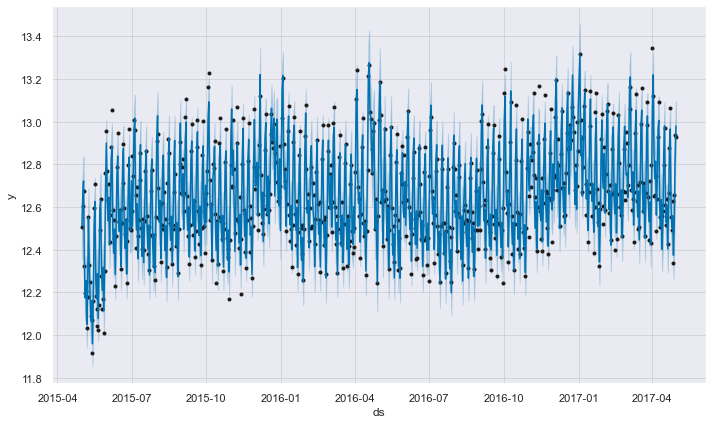

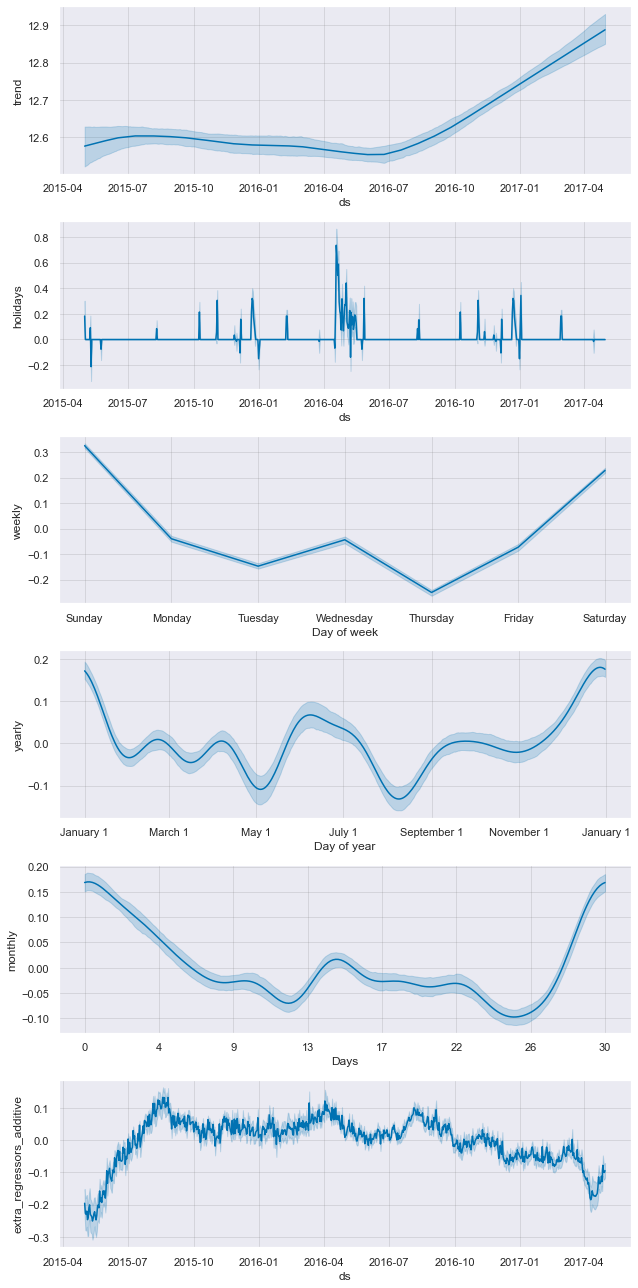

In [59]:
m.fit(future)
forecast = m.predict(future)

fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [46]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Batalla de Pichincha,Batalla de Pichincha_lower,Batalla de Pichincha_upper,Black Friday,...,yearly,yearly_lower,yearly_upper,yellow_maize,yellow_maize_lower,yellow_maize_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-05-01,12.612205,12.397595,12.601627,12.612205,12.612205,0.0,0.0,0.0,0.0,...,-0.102762,-0.102762,-0.102762,-0.114137,-0.114137,-0.114137,0.0,0.0,0.0,12.505056
1,2015-05-02,12.612063,12.554026,12.744135,12.612063,12.612063,0.0,0.0,0.0,0.0,...,-0.105744,-0.105744,-0.105744,-0.114729,-0.114729,-0.114729,0.0,0.0,0.0,12.651918
2,2015-05-03,12.611921,12.635313,12.836408,12.611921,12.611921,0.0,0.0,0.0,0.0,...,-0.107939,-0.107939,-0.107939,-0.115321,-0.115321,-0.115321,0.0,0.0,0.0,12.735055
3,2015-05-04,12.611779,12.251026,12.446224,12.611779,12.611779,0.0,0.0,0.0,0.0,...,-0.109310,-0.109310,-0.109310,-0.115914,-0.115914,-0.115914,0.0,0.0,0.0,12.347052
4,2015-05-05,12.611637,12.082161,12.275631,12.611637,12.611637,0.0,0.0,0.0,0.0,...,-0.109831,-0.109831,-0.109831,-0.116506,-0.116506,-0.116506,0.0,0.0,0.0,12.181327


In [47]:
projection, submodel = m.project(future, ['oil_price'])

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0    12.505056
1    12.651918
2    12.735055
3    12.347052
4    12.181327
Name: y, dtype: float64 0    12.505056
1    12.651918
2    12.735055
3    12.347052
4    12.181327
Name: yhat, dtype: float64


In [45]:
future.head()

,ds,y,onpromotion,oil_price,precipitation,tmax,tmin,tavg,yellow_maize,potatoes
0,2015-05-01,12.508238,7.664816,59.10,0.0,20.3,4.066667,13.95,21.766667,0.295333
1,2015-05-02,12.606216,6.190315,59.10,0.0,21.0,3.700000,13.40,21.783333,0.295667
2,2015-05-03,12.677281,6.180017,59.10,20.1,21.0,6.000000,11.30,21.800000,0.296000
3,2015-05-04,12.323003,6.068426,58.92,16.0,19.0,5.300000,12.10,21.816667,0.296333
4,2015-05-05,12.197967,6.059123,60.38,8.9,20.1,6.800000,11.90,21.833333,0.296667


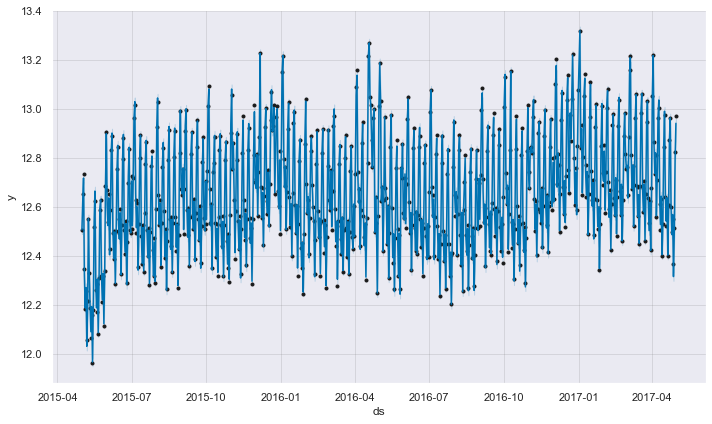

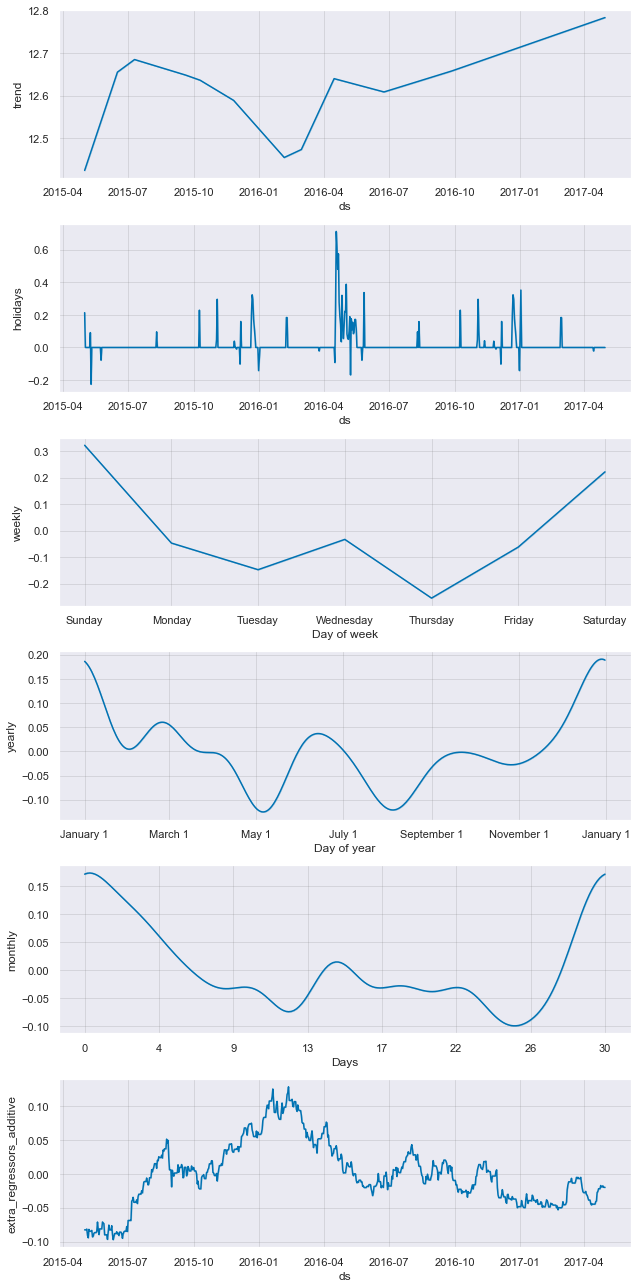

In [44]:
fig1 = submodel.plot(projection)
fig2 = submodel.plot_components(projection)

In [64]:
stan_fit = m.stan_backend.stan_fit
stan_fit.summary().keys()

odict_keys(['summary', 'c_summary', 'summary_rownames', 'summary_colnames', 'c_summary_rownames', 'c_summary_colnames'])

In [71]:
stan_fit.summary()['summary_rownames']

array(['k', 'm', 'delta[1]', 'delta[2]', 'delta[3]', 'delta[4]',
       'delta[5]', 'delta[6]', 'delta[7]', 'delta[8]', 'delta[9]',
       'delta[10]', 'delta[11]', 'delta[12]', 'delta[13]', 'delta[14]',
       'delta[15]', 'delta[16]', 'delta[17]', 'delta[18]', 'delta[19]',
       'delta[20]', 'delta[21]', 'delta[22]', 'delta[23]', 'delta[24]',
       'delta[25]', 'sigma_obs', 'beta[1]', 'beta[2]', 'beta[3]',
       'beta[4]', 'beta[5]', 'beta[6]', 'beta[7]', 'beta[8]', 'beta[9]',
       'beta[10]', 'beta[11]', 'beta[12]', 'beta[13]', 'beta[14]',
       'beta[15]', 'beta[16]', 'beta[17]', 'beta[18]', 'beta[19]',
       'beta[20]', 'beta[21]', 'beta[22]', 'beta[23]', 'beta[24]',
       'beta[25]', 'beta[26]', 'beta[27]', 'beta[28]', 'beta[29]',
       'beta[30]', 'beta[31]', 'beta[32]', 'beta[33]', 'beta[34]',
       'beta[35]', 'beta[36]', 'beta[37]', 'beta[38]', 'beta[39]',
       'beta[40]', 'beta[41]', 'beta[42]', 'beta[43]', 'beta[44]',
       'beta[45]', 'beta[46]', 'beta[47]', '

In [80]:
pars = stan_fit.extract()
pars

OrderedDict([('k',
              array([ 0.03088423,  0.07947581, -0.0130942 ,  0.03924261, -0.0055102 ,
                      0.01043302,  0.03101276,  0.02949441, -0.00455554,  0.03179135,
                      0.01739891,  0.03143386, -0.05567631,  0.02262275,  0.04919773,
                      0.09312978,  0.02121424,  0.08122117,  0.04812924,  0.04397402,
                      0.0056608 ,  0.04502778,  0.00436851,  0.07740869,  0.06209646,
                      0.05224052,  0.01606797, -0.01165065,  0.06158787,  0.02795245,
                     -0.01368329,  0.07995482,  0.1450459 ,  0.04678668,  0.01928193,
                      0.08710775,  0.02347723,  0.15807462,  0.05280719,  0.05054105,
                      0.02248674,  0.01143313,  0.01994074,  0.03630289,  0.0028443 ,
                      0.01180664,  0.0240607 ,  0.01581683, -0.00201502,  0.00736047,
                      0.04443677,  0.02853269,  0.01181663,  0.06294034,  0.07429212,
                      0.01601196,  

In [78]:
upar = stan_fit.unconstrain_pars({'k': 1,'m': 1, 'delta': 25, 'beta': 3})
stan_fit.log_prob(upar)

AttributeError: 'list' object has no attribute 'items'

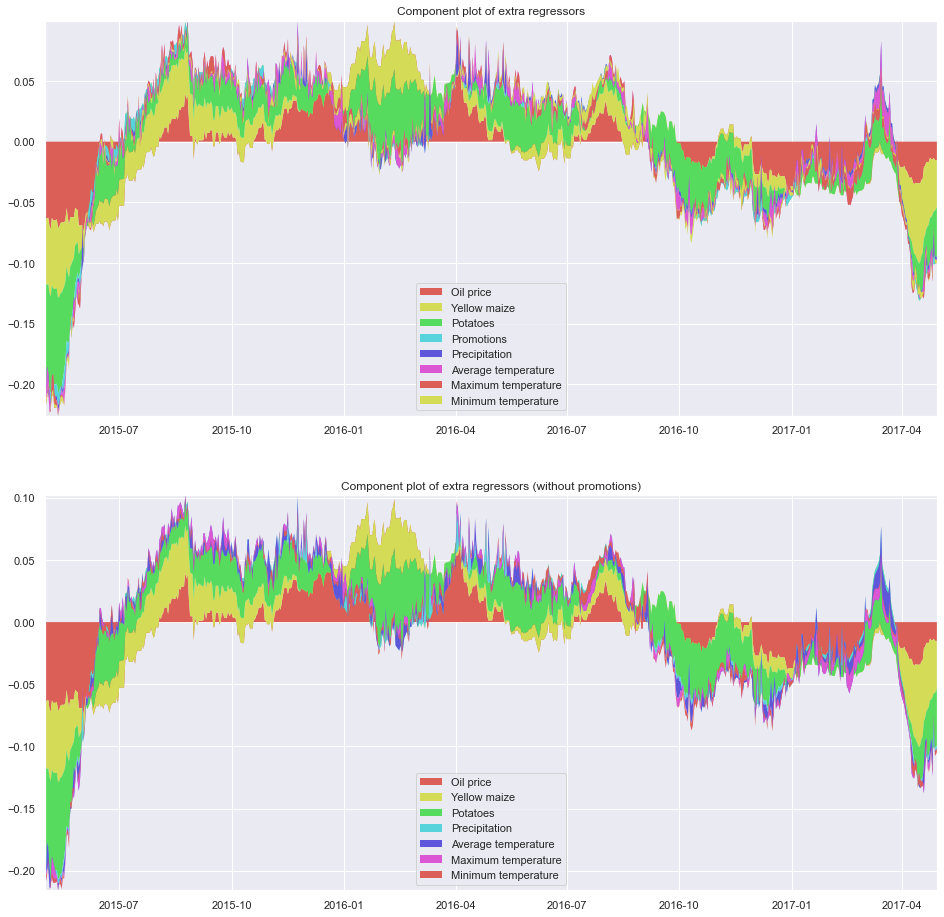

In [23]:

regressors = forecast[['ds', 'oil_price', 'onpromotion', 'potatoes', 'precipitation', 
                       'tavg', 'tmax', 'tmin', 'yellow_maize']]

with sns.color_palette('hls'):
    fig, ax =plt.subplots(2,1, figsize=(16,16))
    ax[0].stackplot(forecast['ds'],  
                  forecast[['oil_price', 'yellow_maize', 'potatoes', 'onpromotion', 'precipitation', 
                            'tavg', 'tmax', 'tmin']].values.T,
                 labels = ['Oil price', 'Yellow maize', 'Potatoes', 'Promotions', 'Precipitation',
                          'Average temperature', 'Maximum temperature', 'Minimum temperature'],
                   edgecolor='none')
    ax[0].legend(loc='lower center')
    ax[0].margins(0,0)
    ax[0].set_title('Component plot of extra regressors')

    ax[1].stackplot(forecast['ds'],  
                  forecast[['oil_price', 'yellow_maize', 'potatoes', 'precipitation', 
                            'tavg', 'tmax', 'tmin']].values.T,
                 labels = ['Oil price', 'Yellow maize', 'Potatoes', 'Precipitation',
                          'Average temperature', 'Maximum temperature', 'Minimum temperature'],
                   edgecolor='none')
    ax[1].legend(loc='lower center')
    ax[1].margins(0,0)
    ax[1].set_title('Component plot of extra regressors (without promotions)')
    plt.show()

(16861.0, 16953.0)

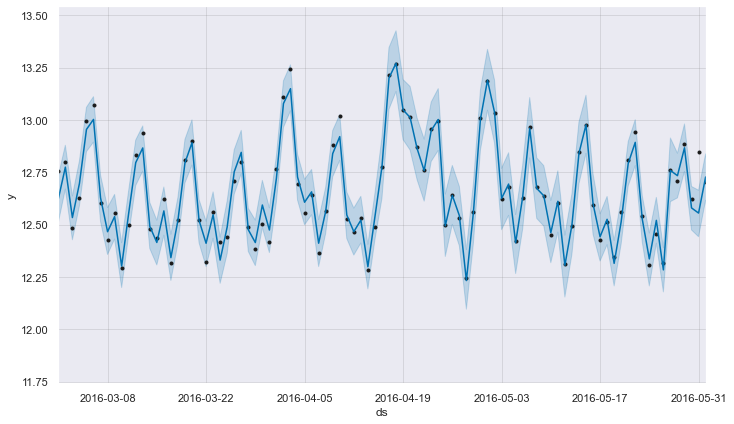

In [39]:
fig3 = m.plot(forecast)
ax = fig3.gca()
ax.set_xlim(pd.to_datetime(['2016-03-01', '2016-06-01'])) 

In [52]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365.25 days', period='60 days', horizon = '30 days')

INFO:prophet:Making 6 forecasts with cutoffs between 2016-06-04 00:00:00 and 2017-03-31 00:00:00


  0%|          | 0/6 [00:00<?, ?it/s]

(16801.0, array([17286.]))

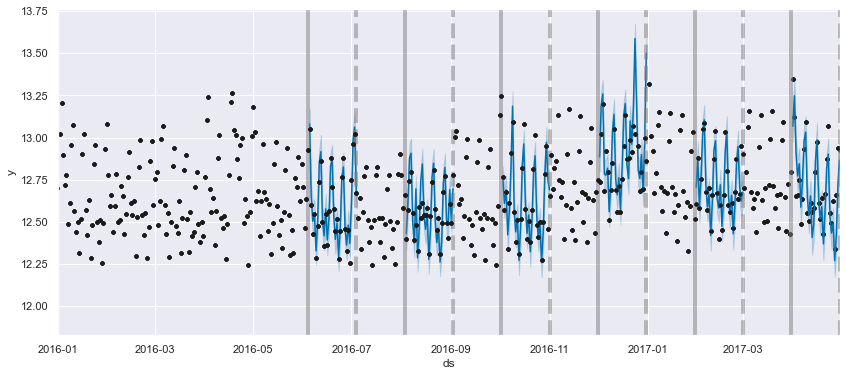

In [54]:
cutoffs = df_cv['cutoff'].unique()
fig = plt.figure(facecolor='w', figsize=(14, 6))
ax = fig.add_subplot(111)
for cut in cutoffs:
    cv = df_cv[df_cv['cutoff'].values == cut]
    ax.plot(m.history['ds'].values, m.history['y'], 'k.')
    ax.plot(cv['ds'].values, cv['yhat'], ls='-', c='#0072B2')
    ax.fill_between(cv['ds'].values, cv['yhat_lower'],
                    cv['yhat_upper'], color='#0072B2',
                    alpha=0.2)
    ax.axvline(x=pd.to_datetime(cut), c='gray', lw=4, alpha=0.5)
    ax.set_ylabel('y')
    ax.set_xlabel('ds')
    ax.axvline(x=pd.to_datetime(cut) + pd.Timedelta('30 days'), c='gray', lw=4,
               alpha=0.5, ls='--')
ax.set_xlim([pd.to_datetime('2016-01-01'),m.history['ds'].tail(1)])

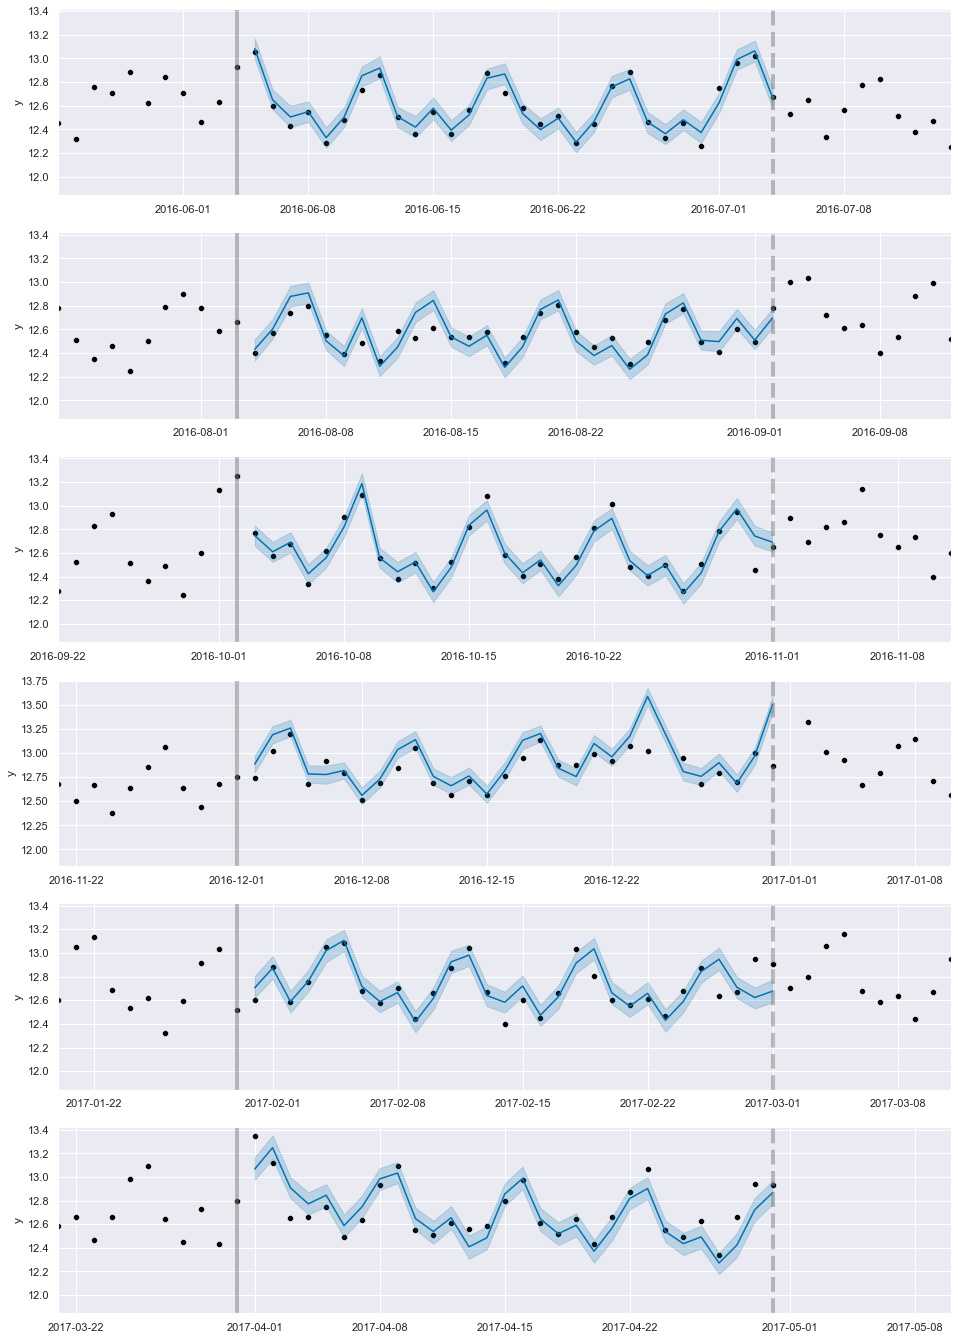

In [55]:
fig, ax = plt.subplots(6,1, figsize=(16,24))
cutoffs = df_cv['cutoff'].unique()
for i, cut in enumerate(cutoffs):
    cv = df_cv[df_cv['cutoff'].values == cut]
    sns.scatterplot(x=m.history['ds'].values, y=m.history['y'], color='black', ax=ax[i])
    sns.lineplot(x=cv['ds'].values, y=cv['yhat'], color='#0072B2', ax=ax[i])
    ax[i].fill_between(cv['ds'].values, cv['yhat_lower'],
                    cv['yhat_upper'], color='#0072B2',
                    alpha=0.2)
    ax[i].axvline(x=pd.to_datetime(cut), c='gray', lw=4, alpha=0.5)
    ax[i].axvline(x=pd.to_datetime(cut) + pd.Timedelta('30 days'), c='gray', lw=4,
               alpha=0.5, ls='--')
    ax[i].set_xlim([pd.to_datetime(cut) - pd.Timedelta('10 days'), pd.to_datetime(cut) + pd.Timedelta('40 days')])

In [59]:
exp_df_cv = df_cv.copy()
exp_df_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = np.exp(exp_df_cv[['yhat', 'yhat_lower', 'yhat_upper', 'y']])

In [65]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(exp_df_cv)
df_p


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,2.785162e+09,52774.635932,36060.070276,0.090426,0.064523,0.086644,0.617647
1,4 days,1.595964e+09,39949.519505,29169.617143,0.082965,0.076745,0.077306,0.607843
2,5 days,1.179859e+09,34349.082901,26371.834193,0.079447,0.076745,0.075991,0.607843
3,6 days,6.544945e+08,25583.090941,20533.314094,0.062072,0.051176,0.061229,0.676471
4,7 days,9.321252e+08,30530.726326,25016.081822,0.075524,0.051939,0.073074,0.607843
5,8 days,7.440069e+08,27276.489467,21290.772328,0.064885,0.050937,0.061947,0.715686
6,9 days,1.055295e+09,32485.307587,24942.875617,0.074252,0.053997,0.071328,0.686275
7,10 days,1.003253e+09,31674.165836,23180.626468,0.070797,0.059178,0.067958,0.764706
8,11 days,1.271904e+09,35663.756495,26216.241827,0.083485,0.059178,0.079010,0.725490
9,12 days,8.775313e+08,29623.154743,21089.915337,0.070305,0.043655,0.066203,0.784314


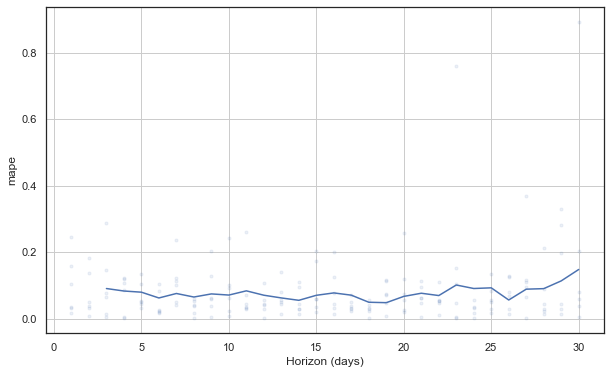

In [63]:

from prophet.plot import plot_cross_validation_metric
with sns.axes_style('white'):
    fig = plot_cross_validation_metric(exp_df_cv, metric='mape')
    #ax = fig.gca()
    #ax.set_ylim(0,130000)